/tmp/ipykernel_640179/3079890232.py:18: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Time'] = pd.to_datetime(df['Time'])


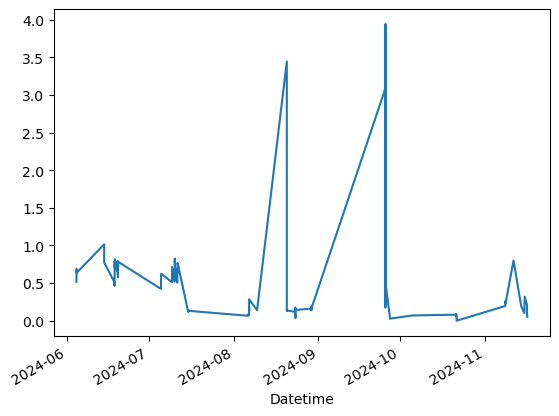

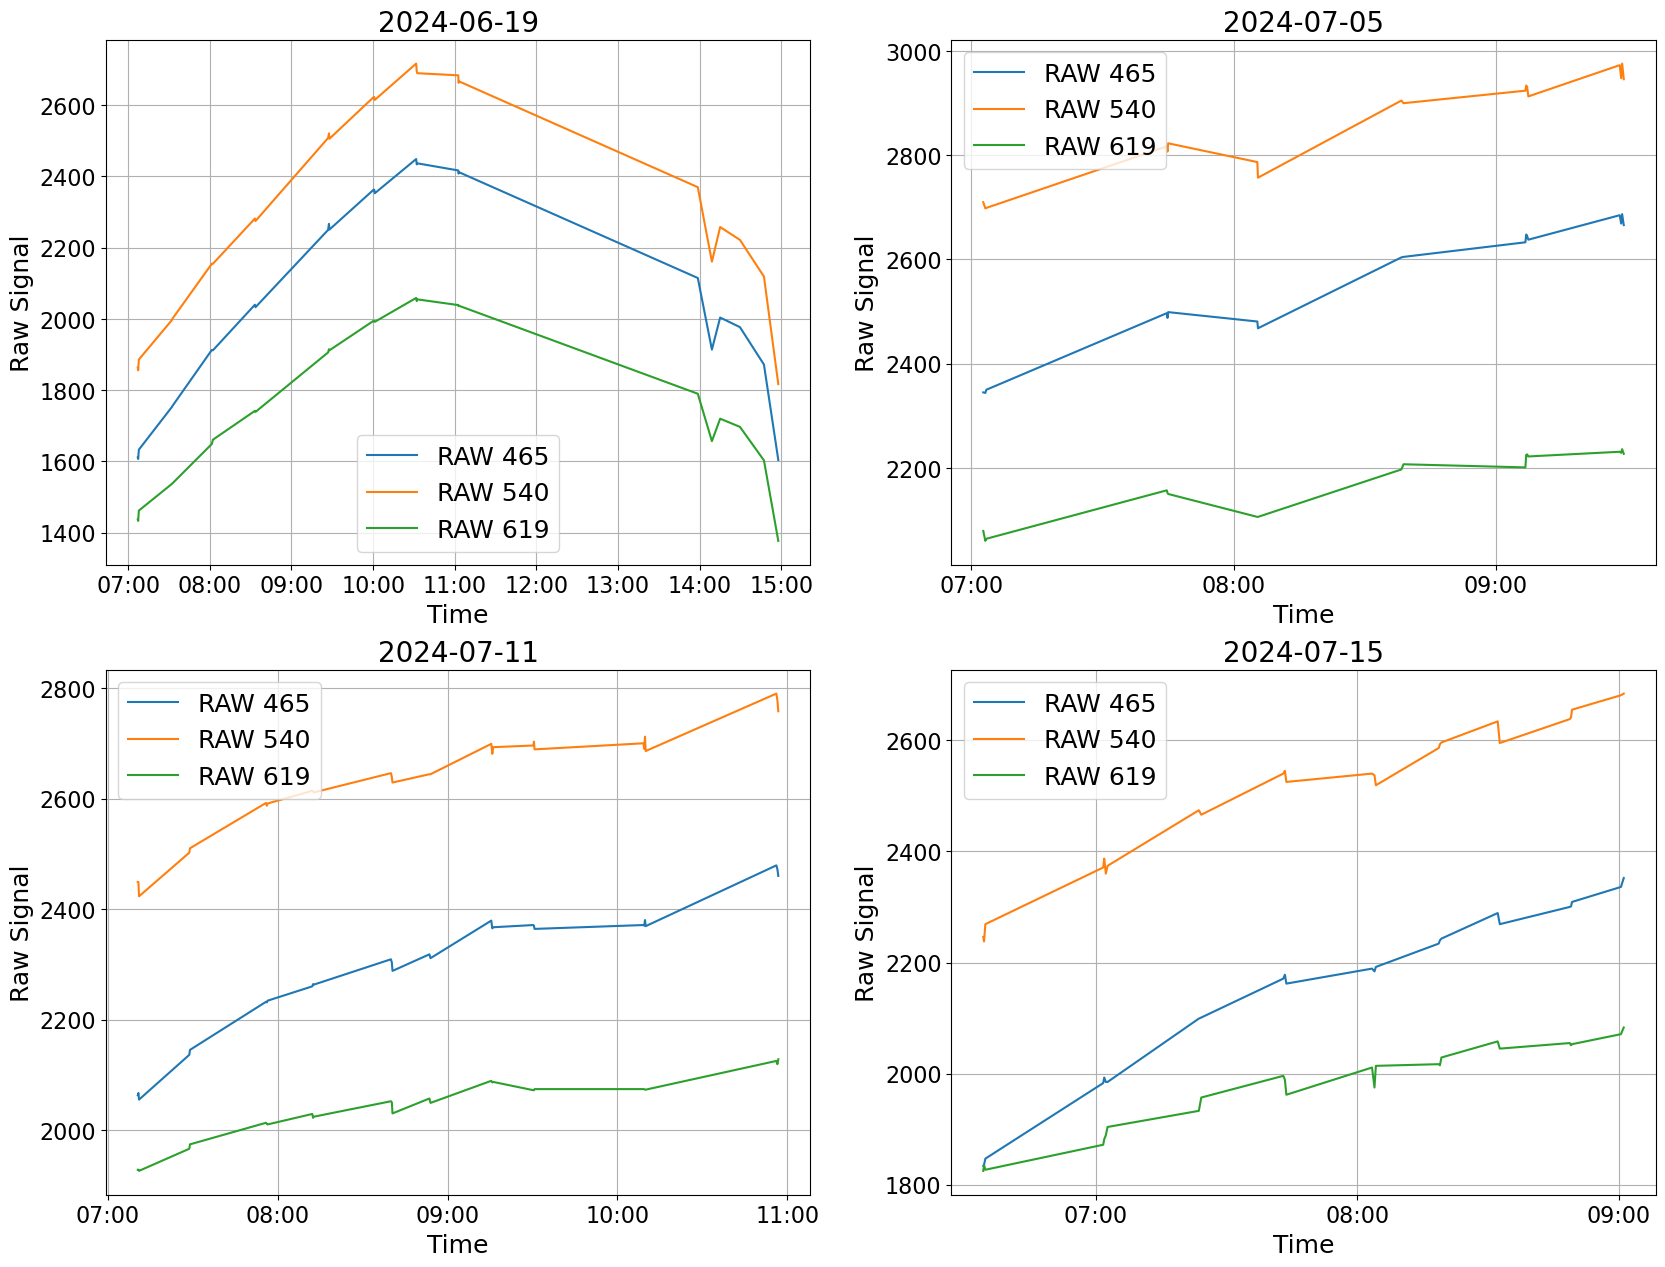

/tmp/ipykernel_640179/3079890232.py:204: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


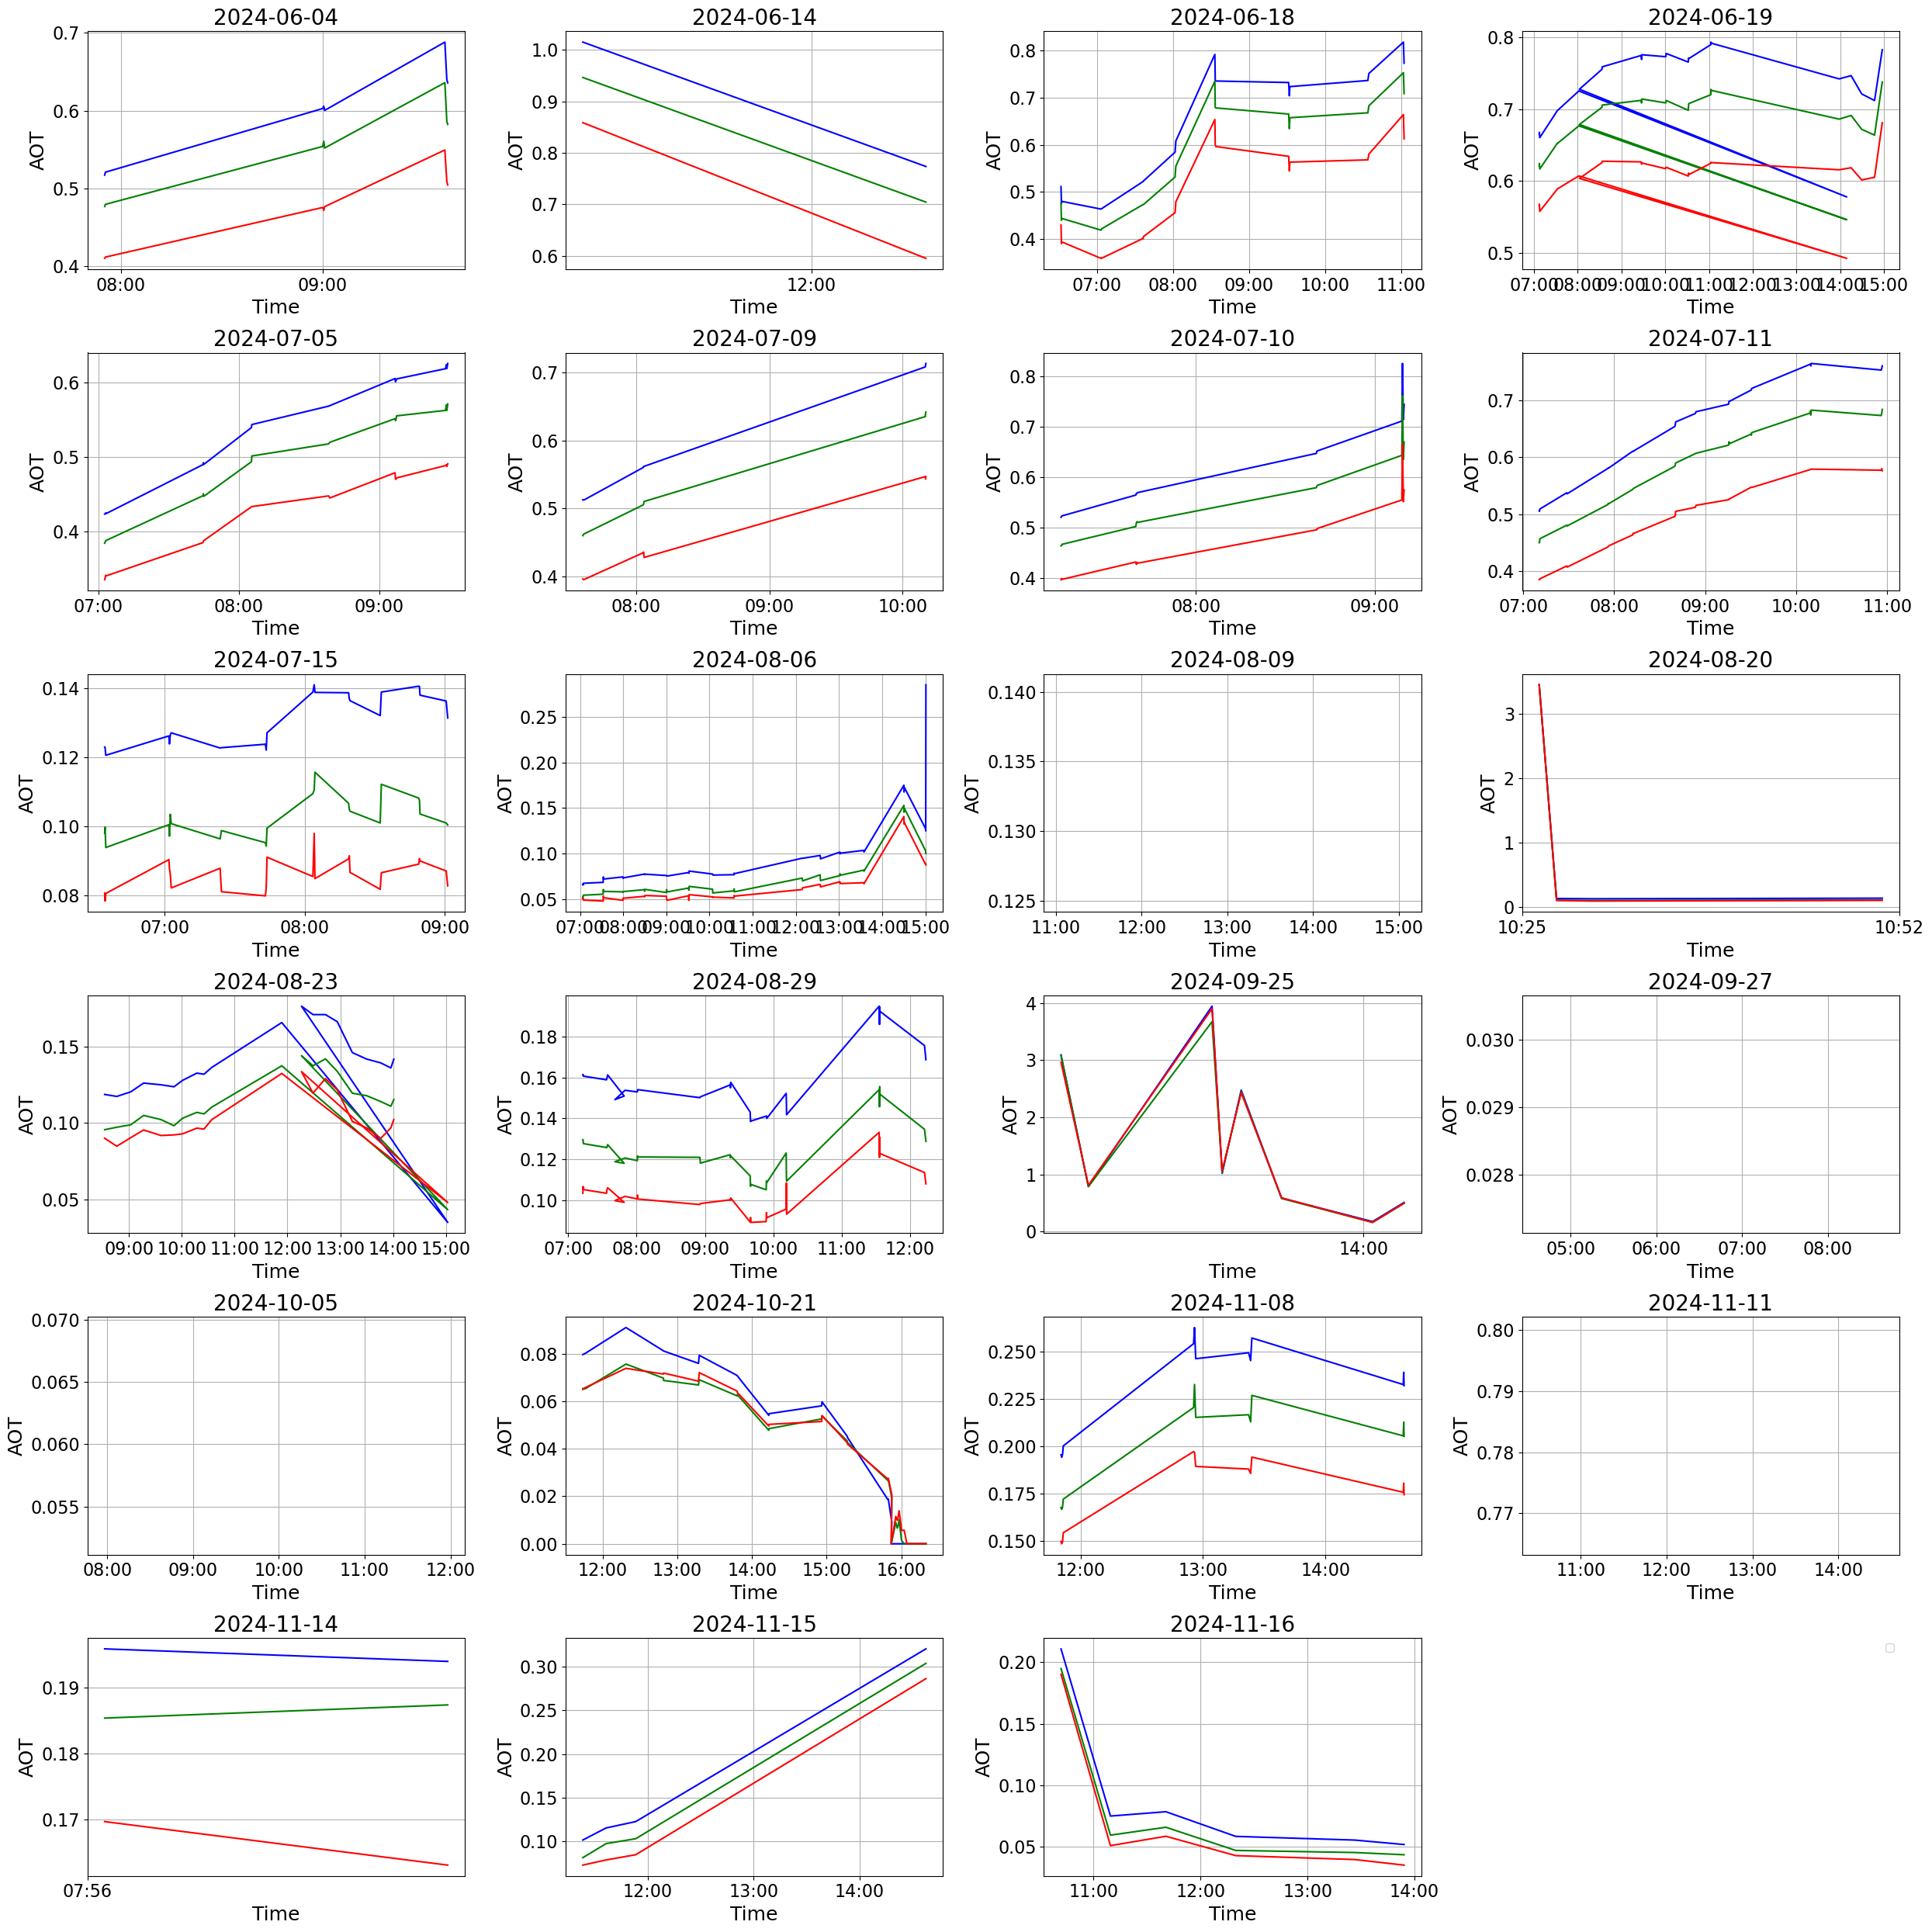

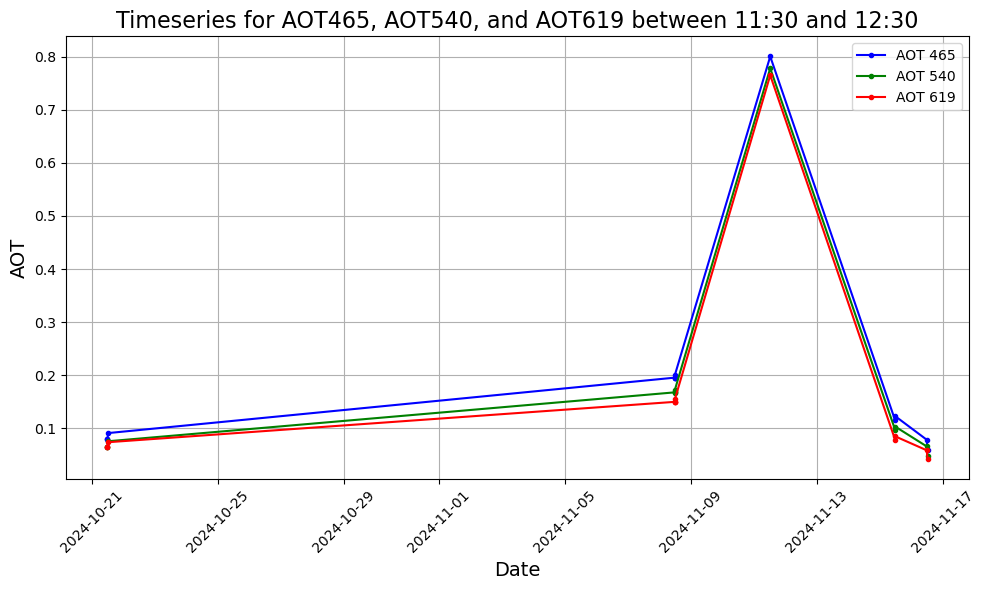

In [9]:
# -*- coding: utf-8 -*-
"""
Created on Sun Nov 24 17:54:31 2024

@author: Valu
"""
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

# import data
df = pd.read_csv(r'data_for_analysis_py_script/0422_data.txt', delimiter=';')


# combine date and time to single datetime column
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])
df['Time'] = pd.to_datetime(df['Time'])

df.set_index('Datetime', inplace=True)

# plot data
df['AOT465'].plot()


######

# subset data for single days
june19 = df[df['Date'] == '2024-06-19']
june19 = june19.sort_values(by='Time') # otherwise strange horizontal line when plotting

july5 = df[df['Date'] == '2024-07-05']
july5 = july5.sort_values(by='Time')

july15 = df[df['Date'] == '2024-07-15']
july15 = july15.sort_values(by='Time')

july11 = df[df['Date'] == '2024-07-11']
july11 = july11.sort_values(by='Time')

# create plots for each day
fig, axes = plt.subplots(2, 2, figsize=(20,15), sharex=False)
axes[0, 0].plot(june19['Time'], june19['RAW465'], label='RAW 465')
axes[0, 0].plot(june19['Time'], june19['RAW540'], label='RAW 540')
axes[0, 0].plot(june19['Time'], june19['RAW619'], label='RAW 619')

axes[0,1].plot(july5['Time'], july5['RAW465'], label='RAW 465')
axes[0,1].plot(july5['Time'], july5['RAW540'], label='RAW 540')
axes[0,1].plot(july5['Time'], july5['RAW619'], label='RAW 619')

axes[1, 0].plot(july11['Time'], july11['RAW465'], label='RAW 465')
axes[1, 0].plot(july11['Time'], july11['RAW540'], label='RAW 540')
axes[1, 0].plot(july11['Time'], july11['RAW619'], label='RAW 619')

axes[1, 1].plot(july15['Time'], july15['RAW465'], label='RAW 465')
axes[1, 1].plot(july15['Time'], july15['RAW540'], label='RAW 540')
axes[1, 1].plot(july15['Time'], july15['RAW619'], label='RAW 619')

axes[0, 0].set_title('2024-06-19', fontsize=20)
axes[0, 1].set_title('2024-07-05', fontsize=20)
axes[1, 0].set_title('2024-07-11', fontsize=20)
axes[1, 1].set_title('2024-07-15', fontsize=20)

for ax in axes.flatten():  # Flatten the axes to iterate over them
    ax.set_xlabel('Time', fontsize=18)
    ax.set_ylabel('Raw Signal', fontsize=18)
    ax.legend(fontsize=18)
    ax.grid(True)

    # Set x-axis to show only full hours
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))  # Every full hour
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))  # Format as HH:MM

    ax.tick_params(labelsize=16)
    
# Display the plot
plt.show()

##### display points on map

import geopandas as gpd
from shapely.geometry import Point

## function to convert DDM to DD coordinates
def ddm_to_dd(ddm_coord):
    """
    Converts Degrees and Decimal Minutes (DDM) to Decimal Degrees (DD),
    handling cases where longitude has leading zeros.
    
    Args:
        ddm_coord (str): Coordinate in DDM format (e.g., "00830.36148E").
    
    Returns:
        float: Coordinate in Decimal Degrees.
    """
    # Extract hemisphere (last character)
    hemisphere = ddm_coord[-1]
    
    # Remove hemisphere from the coordinate
    ddm_coord = ddm_coord[:-1]
    
    # Determine the number of degrees 
    if ddm_coord[0] == '0':  # For longitude with leading zero
        degrees = int(ddm_coord[:3])  # First 3 characters are degrees
        minutes = float(ddm_coord[3:])  # Remaining are minutes
    else:  # For latitude or longitude without leading zero
        degrees = int(ddm_coord[:2])  # First 2 characters are degrees
        minutes = float(ddm_coord[2:])  # Remaining are minutes
    
    # Convert to Decimal Degrees
    decimal_degrees = degrees + (minutes / 60)
    
    # Adjust for hemisphere
    if hemisphere in ['S', 'W']:
        decimal_degrees *= -1
    
    return decimal_degrees

# convert coordinates in df
df['N'] = df['Latitude'].apply(ddm_to_dd)
df['E'] = df['Longitude'].apply(ddm_to_dd)

geometry = [Point(xy) for xy in zip(df['E'], df['N'])]
gdf = gpd.GeoDataFrame(df, geometry=geometry)

import folium

# Define Switzerland's bounding box
# Approximate coordinates for the southwestern and northeastern corners
switzerland_bounds = [[45.81792, 5.95608], [47.80845, 10.49203]]

# Create a Folium map centered in Switzerland
map_switzerland = folium.Map(
    location=[46.8182, 8.2275],  # Switzerland's approximate center
    zoom_start=8,  # Zoom level
    tiles='OpenStreetMap'  # Use OSM tiles
)

# Add a rectangle to show the boundaries of Switzerland
# folium.Rectangle(
#     bounds=switzerland_bounds,
#     color='blue',
#     weight=2,
#     fill=True,
#     fill_opacity=0.2
# ).add_to(map_switzerland)

# Display the map
map_switzerland.save("switzerland_map.html")

# Iterate through the GeoDataFrame and add points as markers
for idx, row in gdf.iterrows():
    folium.Marker(
        location=[row['geometry'].y, row['geometry'].x],  # Latitude, Longitude
          ).add_to(map_switzerland)
    
map_switzerland.save("switzerland_map_with_points.html")

# show daily plots
# To reset the index of the DataFrame
df.reset_index(inplace=True)
unique_days = df['Datetime'].dt.date.unique()

num_days = len(unique_days)
ncols = 4
norws = (num_days + ncols -1) // ncols

fig, axes = plt.subplots(nrows=norws, ncols=ncols, figsize=(25, 25), sharex=False)
# Flatten the axes array to make it easier to iterate
axes = axes.flatten()

# Plot data for each unique day
for i, day in enumerate(unique_days):
    # Filter the DataFrame for the current day
    day_data = df[df['Datetime'].dt.date == day]
    day_data.sort_values(by='Time')
    
    # Plot each signal for the current day
    axes[i].plot(day_data['Time'], day_data['AOT465'], label='RAW 465', color='blue')
    axes[i].plot(day_data['Time'], day_data['AOT540'], label='RAW 540', color='green')
    axes[i].plot(day_data['Time'], day_data['AOT619'], label='RAW 619', color='red')
    
    # Set title
    axes[i].set_title(f'{day}', fontsize=20)
    
    # Customize axes labels and legend
    axes[i].set_xlabel('Time', fontsize=18)
    axes[i].set_ylabel('AOT', fontsize=18)
    #axes[i].legend(fontsize=18)
    axes[i].grid(True)

    
    # Format the x-axis for time
    axes[i].xaxis.set_major_locator(mdates.HourLocator(interval=1))  # Every full hour
    axes[i].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))  # Format as HH:MM
    axes[i].tick_params(labelsize=16)

# Hide empty subplots if there are any
for i in range(num_days, len(axes)):
    axes[i].axis('off')

# Display the plot
plt.tight_layout()
plt.legend()
plt.show()

## plot timeseries around 1200 for dates after 2024-10-05
df_oct_nov = df[df['Datetime'] > '2024-10-05']
df_oct_nov_12oClock = df_oct_nov[(df_oct_nov['Datetime'].dt.hour > 11) & (df_oct_nov['Datetime'].dt.hour < 13)]

df_oct_nov_1130_1230 = df_oct_nov[
    ((df_oct_nov['Datetime'].dt.hour == 11) & (df_oct_nov['Datetime'].dt.minute >= 30)) | 
    ((df_oct_nov['Datetime'].dt.hour == 12) & (df_oct_nov['Datetime'].dt.minute <= 30))
]

plt.figure(figsize=(10, 6))

# Plot each AOT column
plt.plot(df_oct_nov_1130_1230['Datetime'], df_oct_nov_1130_1230['AOT465'], label='AOT 465', color='blue', marker='.')
plt.plot(df_oct_nov_1130_1230['Datetime'], df_oct_nov_1130_1230['AOT540'], label='AOT 540', color='green', marker='.')
plt.plot(df_oct_nov_1130_1230['Datetime'], df_oct_nov_1130_1230['AOT619'], label='AOT 619', color='red', marker='.')

# Adding labels and title
plt.xlabel('Date', fontsize=14)
plt.ylabel('AOT', fontsize=14)
plt.title('Timeseries for AOT465, AOT540, and AOT619 between 11:30 and 12:30', fontsize=16)

# Customize x-axis
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()

# Show plot
plt.tight_layout()
plt.show()
### cluster points within distance x and show timeseries for close lying points



In [8]:
pip install folium

Note: you may need to restart the kernel to use updated packages.
